In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
def extract_sklearn_splits(clf):
    tree = clf.tree_
    splits = []

    def traverse(node_id):
        if tree.feature[node_id] != -2:  # -2 indicates a leaf node
            feature = tree.feature[node_id]
            threshold = tree.threshold[node_id]
            samples = tree.weighted_n_node_samples[node_id]

            # Get impurity decrease
            left = tree.children_left[node_id]
            right = tree.children_right[node_id]
            n = tree.n_node_samples[node_id]
            impurity = tree.impurity[node_id]
            impurity_left = tree.impurity[left]
            impurity_right = tree.impurity[right]
            n_left = tree.n_node_samples[left]
            n_right = tree.n_node_samples[right]
            weighted_impurity = (n_left / n) * impurity_left + (n_right / n) * impurity_right
            impurity_decrease = impurity - weighted_impurity

            splits.append((feature, threshold, impurity_decrease, min(n_left, n_right)))
            traverse(tree.children_left[node_id])
            traverse(tree.children_right[node_id])

    traverse(0)  # Start from the root node
    return splits

def extract_hyperdt_splits(node):
    splits = []

    def traverse(n):
        if n.feature is not None:
            splits.append((n.feature, n.theta, n.score))
            traverse(n.left)
            traverse(n.right)

    traverse(node)
    return splits

# def compare_trees(fhdt, hdt, verbose=0, adjust_for_depth=False):
#     fhdt_splits = extract_sklearn_splits(fhdt.estimator_)
#     hdt_splits = extract_hyperdt_splits(hdt.tree)

#     out, out_ig = [], []
#     for i, (fhdt_split, hdt_split) in enumerate(zip(fhdt_splits, hdt_splits)):
#         fhdt_feature, fhdt_threshold, impurity_decrease, samples = fhdt_split
#         hdt_feature, hdt_threshold, hdt_score = hdt_split

#         # Convert to Klein model
#         fhdt_feature = fhdt_feature + 1
#         fhdt_threshold = np.arctan2(1, fhdt_threshold)
#         match_bool = fhdt_feature == hdt_feature and np.isclose(fhdt_threshold, hdt_threshold, atol=1e-4)
#         imp_match_bool = np.isclose(impurity_decrease, hdt_score, atol=1e-4)

#         out.append(match_bool)
#         out_ig.append(imp_match_bool)
#         if verbose > 0:
#             if verbose > 1 or not match_bool:
#                 print(f"Node {i}:")
#                 print(f"  Faster       -> Feature: {fhdt_feature}, Threshold: {fhdt_threshold}")
#                 print(f"  HyperDT      -> Feature: {hdt_feature}, Threshold: {hdt_threshold}")
#                 print(f"  Impurity: {impurity_decrease:.5f}; HyperDT score: {hdt_score:.5f}; Samples: {int(samples)}")
#                 print(f"  Agreement    -> {'Match' if match_bool else 'No Match'}")
#                 print(f"  Impurity Match: {'Match' if imp_match_bool else 'No Match'}")
#                 print()

#     if adjust_for_depth and len(fhdt_splits) != len(hdt_splits):
#         out += [False] * abs(len(fhdt_splits) - len(hdt_splits))
#         out_ig += [False] * abs(len(fhdt_splits) - len(hdt_splits))
#     if out and out_ig:
#         return np.array(out).mean(), np.array(out_ig).mean()
#     else:
#         return 1, 1

def compare_trees(fhdt, hdt, atol=1e-4, verbose=0):
    """Return (feature/threshold agreement, impurity‑gain agreement)."""

    sk_tree = fhdt.estimator_.tree_

    def feature_map(f_idx):
        # sklearn’s dim→HyperDT dim conversion (assumes timelike_dim==0)
        return f_idx + 1

    def angle_from_threshold(th):
        return np.arctan2(1.0, th)     # cot‑1(th)

    agree, agree_ig = [], []

    def walk(sk_id, hd_node, depth=0):
        # Both are leaves → nothing to compare
        if sk_tree.feature[sk_id] == -2 and hd_node.feature is None:
            return

        # Either one is a leaf → mismatch
        if sk_tree.feature[sk_id] == -2 or hd_node.feature is None:
            agree.append(False)
            agree_ig.append(False)
            return

        # Compare current split
        sk_feat   = feature_map(sk_tree.feature[sk_id])
        sk_theta  = angle_from_threshold(sk_tree.threshold[sk_id])
        hd_feat   = hd_node.feature
        hd_theta  = hd_node.theta

        match     = (sk_feat == hd_feat) and np.isclose(sk_theta, hd_theta, atol=atol)
        imp_match = np.isclose(
            sk_tree.impurity[sk_id] -
            ((sk_tree.n_node_samples[sk_tree.children_left[sk_id]]  / sk_tree.n_node_samples[sk_id]) *
             sk_tree.impurity[sk_tree.children_left[sk_id]] +
             (sk_tree.n_node_samples[sk_tree.children_right[sk_id]] / sk_tree.n_node_samples[sk_id]) *
             sk_tree.impurity[sk_tree.children_right[sk_id]]),
            hd_node.score, atol=atol
        )

        agree.append(match)
        agree_ig.append(imp_match)

        if verbose and (not match or verbose > 1):
            print(f"{'  '*depth}Depth {depth}: "
                  f"sk({sk_feat=}, {sk_theta:.4f})  vs  "
                  f"hd({hd_feat=}, {hd_theta:.4f})  →  "
                  f"{'OK' if match else 'DIFF'}")

        # Descend only if this node matched; otherwise subtrees are incomparable
        if match:
            walk(sk_tree.children_left[sk_id],  hd_node.left,  depth+1)
            walk(sk_tree.children_right[sk_id], hd_node.right, depth+1)

    walk(0, hdt.tree)

    return np.mean(agree) if agree else 1.0, np.mean(agree_ig) if agree_ig else 1.0

def compare_predictions(hdt, fhdt, X, y=None):
    y_pred_hdt = hdt.predict(X)
    y_pred_fhdt = fhdt.predict(X)
    
    if y is not None:
        accuracy_hdt = accuracy_score(y, y_pred_hdt)
        accuracy_fhdt = accuracy_score(y, y_pred_fhdt)
    else:
        accuracy_hdt = None
        accuracy_fhdt = None
    
    return (y_pred_hdt == y_pred_fhdt).mean(), accuracy_hdt, accuracy_fhdt

In [4]:
# Testing copilot completions - multiline version
import numpy as np
import matplotlib.pyplot as plt

from hyperdt.legacy.tree import HyperbolicDecisionTreeClassifier as HDT
from hyperdt.tree import HyperbolicDecisionTreeClassifier as FastHDT
from hyperdt.toy_data import wrapped_normal_mixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import trange

TOTAL_TRIALS = 10_000
N_POINTS = 1_000
SKLEARN_SEED = 2 

np.random.seed(SKLEARN_SEED)
assert (np.random.permutation([0, 1]) == [1, 0]).all() # This is what it takes

# agreement_split = 1.0
# while agreement_split == 1.0:
n_match, n_ig_match, n_mismatch = 0, 0, 0
seed = -1
for i in trange(TOTAL_TRIALS):
    seed += 1
    try:
        X, y = wrapped_normal_mixture(num_points=N_POINTS, seed=seed)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        dt_args = {"max_depth": 1, "min_samples_leaf": 1, "min_samples_split": 2}

        hdt = HDT(**dt_args)
        hdt.fit(X_train, y_train)    

        fhdt = FastHDT(**dt_args, random_state=SKLEARN_SEED) # Prevent permuting features randomly
        fhdt.fit(X_train, y_train)

        agreement_train, accuracy_hdt_train, accuracy_fhdt_train = compare_predictions(hdt, fhdt, X_train, y_train)
        agreement_test, accuracy_hdt_test, accuracy_fhdt_test = compare_predictions(hdt, fhdt, X_test, y_test)
        agreement_split, agreement_ig = compare_trees(fhdt, hdt, verbose=1)

        if agreement_split:
            n_match += 1
        elif agreement_ig:
            n_ig_match += 1
        else:
            n_mismatch += 1
    except Exception as e:
        print(f"Error on trial {i}: {e}")

print(f"Match: {n_match}, IG Match: {n_ig_match}, Mismatch: {n_mismatch} ")
    
# print(f"accuracy_hdt_train: {accuracy_hdt_train}, accuracy_fhdt_train: {accuracy_fhdt_train}")
# print(f"accuracy_hdt_test: {accuracy_hdt_test}, accuracy_fhdt_test: {accuracy_fhdt_test}")
# print(f"agreement_train: {agreement_train}, agreement_test: {agreement_test}, agreement_split: {agreement_split}")


  0%|          | 0/10000 [00:00<?, ?it/s]

  2%|▏         | 222/10000 [00:53<39:43,  4.10it/s]

Node 0:
  Faster       -> Feature: 2, Threshold: 1.9665381936768642
  HyperDT      -> Feature: 2, Threshold: 1.9880820238665975
  Impurity: 0.18965; HyperDT score: 0.18815; Samples: 166
  Agreement    -> No Match
  Impurity Match: No Match



  3%|▎         | 267/10000 [01:04<39:20,  4.12it/s]

Node 0:
  Faster       -> Feature: 2, Threshold: 2.1357338810455557
  HyperDT      -> Feature: 2, Threshold: 2.193448337970202
  Impurity: 0.46219; HyperDT score: 0.46219; Samples: 290
  Agreement    -> No Match
  Impurity Match: Match



  3%|▎         | 285/10000 [01:09<38:18,  4.23it/s]

Node 0:
  Faster       -> Feature: 2, Threshold: 2.279162087607126
  HyperDT      -> Feature: 2, Threshold: 2.2794572987328734
  Impurity: 0.11296; HyperDT score: 0.11296; Samples: 104
  Agreement    -> No Match
  Impurity Match: Match



  3%|▎         | 325/10000 [01:18<39:14,  4.11it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 2.0282711857173092
  HyperDT      -> Feature: 1, Threshold: 2.0296198268309857
  Impurity: 0.00279; HyperDT score: 0.00279; Samples: 51
  Agreement    -> No Match
  Impurity Match: Match



  5%|▍         | 473/10000 [01:54<38:43,  4.10it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 0.8674869624195228
  HyperDT      -> Feature: 1, Threshold: 0.8679422030953684
  Impurity: 0.35357; HyperDT score: 0.35357; Samples: 191
  Agreement    -> No Match
  Impurity Match: Match



  5%|▍         | 479/10000 [01:56<38:18,  4.14it/s]

Node 0:
  Faster       -> Feature: 2, Threshold: 2.3487691770349977
  HyperDT      -> Feature: 2, Threshold: 2.3489547444029766
  Impurity: 0.49258; HyperDT score: 0.49258; Samples: 374
  Agreement    -> No Match
  Impurity Match: Match



  5%|▌         | 542/10000 [02:11<38:38,  4.08it/s]

Node 0:
  Faster       -> Feature: 2, Threshold: 1.0424405880390148
  HyperDT      -> Feature: 2, Threshold: 1.0392963549424363
  Impurity: 0.08546; HyperDT score: 0.08534; Samples: 157
  Agreement    -> No Match
  Impurity Match: No Match



 11%|█         | 1089/10000 [04:24<37:05,  4.00it/s]

Node 0:
  Faster       -> Feature: 2, Threshold: 1.5495496798603068
  HyperDT      -> Feature: 2, Threshold: 1.5127319705417726
  Impurity: 0.28302; HyperDT score: 0.28277; Samples: 163
  Agreement    -> No Match
  Impurity Match: No Match



 11%|█         | 1099/10000 [04:27<37:10,  3.99it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 1.9384652933771245
  HyperDT      -> Feature: 1, Threshold: 1.9704865798824445
  Impurity: 0.33612; HyperDT score: 0.33612; Samples: 171
  Agreement    -> No Match
  Impurity Match: Match



 13%|█▎        | 1344/10000 [05:26<35:30,  4.06it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 2.234661061915797
  HyperDT      -> Feature: 1, Threshold: 2.239021749782626
  Impurity: 0.49750; HyperDT score: 0.49750; Samples: 398
  Agreement    -> No Match
  Impurity Match: Match



 15%|█▍        | 1499/10000 [06:04<35:08,  4.03it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 1.3098619165286525
  HyperDT      -> Feature: 1, Threshold: 1.3100558713339885
  Impurity: 0.18125; HyperDT score: 0.18125; Samples: 171
  Agreement    -> No Match
  Impurity Match: Match



 16%|█▌        | 1622/10000 [06:34<34:02,  4.10it/s]

Node 0:
  Faster       -> Feature: 2, Threshold: 1.220934015585366
  HyperDT      -> Feature: 2, Threshold: 1.2240179695393363
  Impurity: 0.34372; HyperDT score: 0.34171; Samples: 246
  Agreement    -> No Match
  Impurity Match: No Match



 20%|██        | 2007/10000 [08:07<33:25,  3.99it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 1.694476832597221
  HyperDT      -> Feature: 1, Threshold: 1.6962625898009827
  Impurity: 0.40566; HyperDT score: 0.40566; Samples: 306
  Agreement    -> No Match
  Impurity Match: Match



 21%|██        | 2056/10000 [08:19<29:29,  4.49it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 2.2068652564311315
  HyperDT      -> Feature: 2, Threshold: 1.2230375917769964
  Impurity: 0.31350; HyperDT score: 0.31249; Samples: 340
  Agreement    -> No Match
  Impurity Match: No Match



 22%|██▏       | 2217/10000 [08:58<31:48,  4.08it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 1.8484137052466711
  HyperDT      -> Feature: 1, Threshold: 1.854840675685011
  Impurity: 0.39417; HyperDT score: 0.39417; Samples: 395
  Agreement    -> No Match
  Impurity Match: Match



 23%|██▎       | 2329/10000 [09:25<31:43,  4.03it/s]

Node 0:
  Faster       -> Feature: 2, Threshold: 1.0899439519784924
  HyperDT      -> Feature: 2, Threshold: 1.102544869966649
  Impurity: 0.21329; HyperDT score: 0.21209; Samples: 373
  Agreement    -> No Match
  Impurity Match: No Match



 26%|██▌       | 2568/10000 [10:23<30:16,  4.09it/s]

Node 0:
  Faster       -> Feature: 2, Threshold: 1.5506731899173207
  HyperDT      -> Feature: 2, Threshold: 1.5438501996278515
  Impurity: 0.13016; HyperDT score: 0.12840; Samples: 102
  Agreement    -> No Match
  Impurity Match: No Match



 26%|██▋       | 2637/10000 [10:40<29:00,  4.23it/s]

Node 0:
  Faster       -> Feature: 2, Threshold: 2.317982963730245
  HyperDT      -> Feature: 2, Threshold: 2.317723705005032
  Impurity: 0.09320; HyperDT score: 0.09307; Samples: 308
  Agreement    -> No Match
  Impurity Match: No Match



 29%|██▊       | 2863/10000 [11:35<29:06,  4.09it/s]

Node 0:
  Faster       -> Feature: 2, Threshold: 1.185245044189103
  HyperDT      -> Feature: 2, Threshold: 1.1855981796703767
  Impurity: 0.26411; HyperDT score: 0.26411; Samples: 324
  Agreement    -> No Match
  Impurity Match: Match



 30%|██▉       | 2976/10000 [12:03<28:09,  4.16it/s]

Node 0:
  Faster       -> Feature: 2, Threshold: 2.3387491031123075
  HyperDT      -> Feature: 2, Threshold: 2.3495966312567003
  Impurity: 0.18399; HyperDT score: 0.18399; Samples: 82
  Agreement    -> No Match
  Impurity Match: Match



 32%|███▏      | 3177/10000 [12:52<25:33,  4.45it/s]

Node 0:
  Faster       -> Feature: 2, Threshold: 1.757957709519394
  HyperDT      -> Feature: 2, Threshold: 1.741086289709299
  Impurity: 0.11834; HyperDT score: 0.11819; Samples: 345
  Agreement    -> No Match
  Impurity Match: No Match



 32%|███▏      | 3218/10000 [13:02<28:24,  3.98it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 2.1176055345033014
  HyperDT      -> Feature: 1, Threshold: 2.0729645687810545
  Impurity: 0.20666; HyperDT score: 0.20656; Samples: 220
  Agreement    -> No Match
  Impurity Match: Match



 33%|███▎      | 3275/10000 [13:16<28:08,  3.98it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 1.9193902764862532
  HyperDT      -> Feature: 1, Threshold: 1.9231167801839886
  Impurity: 0.20727; HyperDT score: 0.20727; Samples: 184
  Agreement    -> No Match
  Impurity Match: Match



 33%|███▎      | 3298/10000 [13:22<25:40,  4.35it/s]

Node 0:
  Faster       -> Feature: 2, Threshold: 1.9979932504712106
  HyperDT      -> Feature: 2, Threshold: 1.9989156333559803
  Impurity: 0.38096; HyperDT score: 0.38096; Samples: 360
  Agreement    -> No Match
  Impurity Match: Match



 35%|███▍      | 3468/10000 [14:03<27:11,  4.00it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 0.9908687662403957
  HyperDT      -> Feature: 1, Threshold: 0.9916851731961469
  Impurity: 0.20560; HyperDT score: 0.20560; Samples: 136
  Agreement    -> No Match
  Impurity Match: Match



 38%|███▊      | 3765/10000 [15:11<25:26,  4.08it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 2.055410744296545
  HyperDT      -> Feature: 1, Threshold: 2.0598261497237127
  Impurity: 0.49939; HyperDT score: 0.49939; Samples: 386
  Agreement    -> No Match
  Impurity Match: Match



 38%|███▊      | 3843/10000 [15:30<25:21,  4.05it/s]

Node 0:
  Faster       -> Feature: 2, Threshold: 1.6372399330286034
  HyperDT      -> Feature: 2, Threshold: 1.6385261440195718
  Impurity: 0.19726; HyperDT score: 0.19726; Samples: 299
  Agreement    -> No Match
  Impurity Match: Match



 39%|███▉      | 3887/10000 [15:41<24:38,  4.13it/s]

Node 0:
  Faster       -> Feature: 2, Threshold: 2.243415769350429
  HyperDT      -> Feature: 2, Threshold: 2.3390393713764
  Impurity: 0.39762; HyperDT score: 0.39762; Samples: 219
  Agreement    -> No Match
  Impurity Match: Match



 39%|███▉      | 3918/10000 [15:48<25:13,  4.02it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 2.0576122733139575
  HyperDT      -> Feature: 1, Threshold: 1.951730022404191
  Impurity: 0.22344; HyperDT score: 0.22282; Samples: 329
  Agreement    -> No Match
  Impurity Match: No Match



 40%|███▉      | 3978/10000 [16:03<25:34,  3.92it/s]

Node 0:
  Faster       -> Feature: 2, Threshold: 2.294230656154703
  HyperDT      -> Feature: 2, Threshold: 2.294624992228919
  Impurity: 0.10672; HyperDT score: 0.10672; Samples: 362
  Agreement    -> No Match
  Impurity Match: Match



 40%|████      | 4035/10000 [16:17<24:33,  4.05it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 1.555724178261209
  HyperDT      -> Feature: 1, Threshold: 1.5582969295052338
  Impurity: 0.12676; HyperDT score: 0.12676; Samples: 347
  Agreement    -> No Match
  Impurity Match: Match



 41%|████      | 4064/10000 [16:23<24:08,  4.10it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 0.8440988122621574
  HyperDT      -> Feature: 1, Threshold: 0.8452204301305897
  Impurity: 0.20891; HyperDT score: 0.20891; Samples: 393
  Agreement    -> No Match
  Impurity Match: Match



 41%|████      | 4084/10000 [16:28<21:31,  4.58it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 0.826976105142264
  HyperDT      -> Feature: 1, Threshold: 0.8278825699569364
  Impurity: 0.15075; HyperDT score: 0.15075; Samples: 294
  Agreement    -> No Match
  Impurity Match: Match



 42%|████▏     | 4230/10000 [17:00<23:03,  4.17it/s]

Node 0:
  Faster       -> Feature: 2, Threshold: 2.1031056129235854
  HyperDT      -> Feature: 2, Threshold: 2.1230021481358827
  Impurity: 0.15114; HyperDT score: 0.14989; Samples: 133
  Agreement    -> No Match
  Impurity Match: No Match



 45%|████▍     | 4482/10000 [18:02<23:06,  3.98it/s]

Node 0:
  Faster       -> Feature: 2, Threshold: 1.6560271059812552
  HyperDT      -> Feature: 2, Threshold: 1.6566823617990776
  Impurity: 0.12685; HyperDT score: 0.12685; Samples: 66
  Agreement    -> No Match
  Impurity Match: Match



 45%|████▍     | 4490/10000 [18:04<22:21,  4.11it/s]

Error on trial 4489: Points must lie on a hyperboloid: Minkowski norm must equal -1/curvature.


 49%|████▉     | 4901/10000 [19:34<20:26,  4.16it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 2.1457603141875534
  HyperDT      -> Feature: 1, Threshold: 2.1459097080766987
  Impurity: 0.10910; HyperDT score: 0.10910; Samples: 314
  Agreement    -> No Match
  Impurity Match: Match



 53%|█████▎    | 5318/10000 [21:08<16:57,  4.60it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 0.9064097153486227
  HyperDT      -> Feature: 1, Threshold: 0.9096802655183968
  Impurity: 0.26486; HyperDT score: 0.26486; Samples: 361
  Agreement    -> No Match
  Impurity Match: Match



 55%|█████▍    | 5479/10000 [21:44<16:26,  4.58it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 1.7129734597369892
  HyperDT      -> Feature: 1, Threshold: 1.8806662314108993
  Impurity: 0.18286; HyperDT score: 0.18224; Samples: 233
  Agreement    -> No Match
  Impurity Match: No Match



 58%|█████▊    | 5786/10000 [22:51<15:09,  4.63it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 1.6716416077820633
  HyperDT      -> Feature: 1, Threshold: 1.664593119384669
  Impurity: 0.09094; HyperDT score: 0.09061; Samples: 117
  Agreement    -> No Match
  Impurity Match: No Match



 59%|█████▉    | 5875/10000 [23:10<14:51,  4.62it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 2.1424935728459755
  HyperDT      -> Feature: 1, Threshold: 2.1645052465659305
  Impurity: 0.46068; HyperDT score: 0.46065; Samples: 305
  Agreement    -> No Match
  Impurity Match: Match



 66%|██████▌   | 6574/10000 [25:42<12:19,  4.63it/s]

Node 0:
  Faster       -> Feature: 2, Threshold: 0.8383671042753712
  HyperDT      -> Feature: 2, Threshold: 0.8386386841650753
  Impurity: 0.41769; HyperDT score: 0.41569; Samples: 305
  Agreement    -> No Match
  Impurity Match: No Match



 67%|██████▋   | 6667/10000 [26:03<13:29,  4.12it/s]

Node 0:
  Faster       -> Feature: 2, Threshold: 1.477501750401162
  HyperDT      -> Feature: 2, Threshold: 1.4847919288115992
  Impurity: 0.16044; HyperDT score: 0.16013; Samples: 220
  Agreement    -> No Match
  Impurity Match: No Match



 67%|██████▋   | 6708/10000 [26:13<13:22,  4.10it/s]

Node 0:
  Faster       -> Feature: 2, Threshold: 2.083778003487428
  HyperDT      -> Feature: 2, Threshold: 2.071455319419842
  Impurity: 0.27606; HyperDT score: 0.27578; Samples: 263
  Agreement    -> No Match
  Impurity Match: No Match



 67%|██████▋   | 6727/10000 [26:18<13:37,  4.00it/s]

Node 0:
  Faster       -> Feature: 2, Threshold: 2.2403422701685565
  HyperDT      -> Feature: 2, Threshold: 2.2415373835679855
  Impurity: 0.35171; HyperDT score: 0.34997; Samples: 388
  Agreement    -> No Match
  Impurity Match: No Match



 72%|███████▏  | 7230/10000 [28:12<09:55,  4.65it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 0.9941265613139562
  HyperDT      -> Feature: 1, Threshold: 1.0017871442634103
  Impurity: 0.22956; HyperDT score: 0.22951; Samples: 355
  Agreement    -> No Match
  Impurity Match: Match



 72%|███████▏  | 7232/10000 [28:13<09:55,  4.65it/s]

Node 0:
  Faster       -> Feature: 2, Threshold: 2.1059808464887078
  HyperDT      -> Feature: 2, Threshold: 2.107638426951144
  Impurity: 0.48586; HyperDT score: 0.48586; Samples: 381
  Agreement    -> No Match
  Impurity Match: Match



 74%|███████▍  | 7422/10000 [28:54<09:18,  4.61it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 2.139937637853389
  HyperDT      -> Feature: 1, Threshold: 2.2303863118722402
  Impurity: 0.49772; HyperDT score: 0.49772; Samples: 373
  Agreement    -> No Match
  Impurity Match: Match



 75%|███████▌  | 7521/10000 [29:16<08:55,  4.63it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 2.290250494085216
  HyperDT      -> Feature: 1, Threshold: 2.292270735727618
  Impurity: 0.13296; HyperDT score: 0.13296; Samples: 59
  Agreement    -> No Match
  Impurity Match: Match



 80%|███████▉  | 7951/10000 [30:49<06:53,  4.96it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 2.003952138153427
  HyperDT      -> Feature: 1, Threshold: 2.005502743263585
  Impurity: 0.23769; HyperDT score: 0.23769; Samples: 193
  Agreement    -> No Match
  Impurity Match: Match



 80%|███████▉  | 7973/10000 [30:54<07:17,  4.63it/s]

Node 0:
  Faster       -> Feature: 2, Threshold: 1.1960761006224099
  HyperDT      -> Feature: 2, Threshold: 1.1965647813353364
  Impurity: 0.26770; HyperDT score: 0.26770; Samples: 395
  Agreement    -> No Match
  Impurity Match: Match



 82%|████████▏ | 8182/10000 [31:43<07:25,  4.08it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 1.5960040945500686
  HyperDT      -> Feature: 1, Threshold: 1.5971620451737112
  Impurity: 0.12037; HyperDT score: 0.12037; Samples: 112
  Agreement    -> No Match
  Impurity Match: Match



 82%|████████▏ | 8209/10000 [31:49<06:29,  4.59it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 2.10344832622781
  HyperDT      -> Feature: 1, Threshold: 2.3142907781067033
  Impurity: 0.47580; HyperDT score: 0.47580; Samples: 312
  Agreement    -> No Match
  Impurity Match: Match



 88%|████████▊ | 8764/10000 [33:49<04:27,  4.62it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 2.322147020127503
  HyperDT      -> Feature: 1, Threshold: 2.322430185011507
  Impurity: 0.18423; HyperDT score: 0.18423; Samples: 176
  Agreement    -> No Match
  Impurity Match: Match



 88%|████████▊ | 8791/10000 [33:55<04:21,  4.61it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 2.2067942331772588
  HyperDT      -> Feature: 1, Threshold: 2.208444586458487
  Impurity: 0.40126; HyperDT score: 0.40126; Samples: 239
  Agreement    -> No Match
  Impurity Match: Match



 88%|████████▊ | 8836/10000 [34:05<04:14,  4.57it/s]

Node 0:
  Faster       -> Feature: 2, Threshold: 1.8410253019420368
  HyperDT      -> Feature: 2, Threshold: 1.8421160772052394
  Impurity: 0.37458; HyperDT score: 0.37434; Samples: 396
  Agreement    -> No Match
  Impurity Match: No Match



 89%|████████▉ | 8926/10000 [34:24<03:52,  4.62it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 1.9189338765626287
  HyperDT      -> Feature: 1, Threshold: 1.9259689921959213
  Impurity: 0.07572; HyperDT score: 0.07396; Samples: 59
  Agreement    -> No Match
  Impurity Match: No Match



 89%|████████▉ | 8939/10000 [34:27<03:47,  4.66it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 2.2777477310996974
  HyperDT      -> Feature: 1, Threshold: 2.2778985978389477
  Impurity: 0.28999; HyperDT score: 0.28999; Samples: 214
  Agreement    -> No Match
  Impurity Match: Match



 93%|█████████▎| 9308/10000 [35:52<02:47,  4.13it/s]

Node 0:
  Faster       -> Feature: 2, Threshold: 2.2996780067266216
  HyperDT      -> Feature: 2, Threshold: 2.297969834782584
  Impurity: 0.08038; HyperDT score: 0.07937; Samples: 134
  Agreement    -> No Match
  Impurity Match: No Match



 94%|█████████▍| 9414/10000 [36:18<02:26,  4.01it/s]

Node 0:
  Faster       -> Feature: 2, Threshold: 1.1772706301519131
  HyperDT      -> Feature: 2, Threshold: 1.1810110389774793
  Impurity: 0.22099; HyperDT score: 0.22099; Samples: 182
  Agreement    -> No Match
  Impurity Match: Match



 94%|█████████▍| 9440/10000 [36:25<02:17,  4.08it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 2.267583042633631
  HyperDT      -> Feature: 1, Threshold: 2.2680099512941165
  Impurity: 0.11057; HyperDT score: 0.11057; Samples: 162
  Agreement    -> No Match
  Impurity Match: Match



 96%|█████████▌| 9603/10000 [37:05<01:36,  4.11it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 0.8650329972033828
  HyperDT      -> Feature: 1, Threshold: 0.8599766809680044
  Impurity: 0.47025; HyperDT score: 0.46789; Samples: 370
  Agreement    -> No Match
  Impurity Match: No Match



 96%|█████████▌| 9610/10000 [37:06<01:36,  4.06it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 1.1756993833068194
  HyperDT      -> Feature: 1, Threshold: 1.1758847951754585
  Impurity: 0.21316; HyperDT score: 0.21316; Samples: 284
  Agreement    -> No Match
  Impurity Match: Match



 96%|█████████▋| 9626/10000 [37:10<01:33,  3.98it/s]

Node 0:
  Faster       -> Feature: 1, Threshold: 2.2703951957476947
  HyperDT      -> Feature: 1, Threshold: 2.2708135048167586
  Impurity: 0.01598; HyperDT score: 0.01598; Samples: 233
  Agreement    -> No Match
  Impurity Match: Match



 98%|█████████▊| 9757/10000 [37:43<01:01,  3.98it/s]

Node 0:
  Faster       -> Feature: 2, Threshold: 1.0348041790807785
  HyperDT      -> Feature: 2, Threshold: 1.035561206574827
  Impurity: 0.30649; HyperDT score: 0.30485; Samples: 296
  Agreement    -> No Match
  Impurity Match: No Match



 98%|█████████▊| 9808/10000 [37:55<00:47,  4.01it/s]

Node 0:
  Faster       -> Feature: 2, Threshold: 2.129342299797123
  HyperDT      -> Feature: 2, Threshold: 2.1322999690340154
  Impurity: 0.36920; HyperDT score: 0.36920; Samples: 360
  Agreement    -> No Match
  Impurity Match: Match



100%|██████████| 10000/10000 [38:43<00:00,  4.30it/s]

Match: 9934, IG Match: 43, Mismatch: 22 


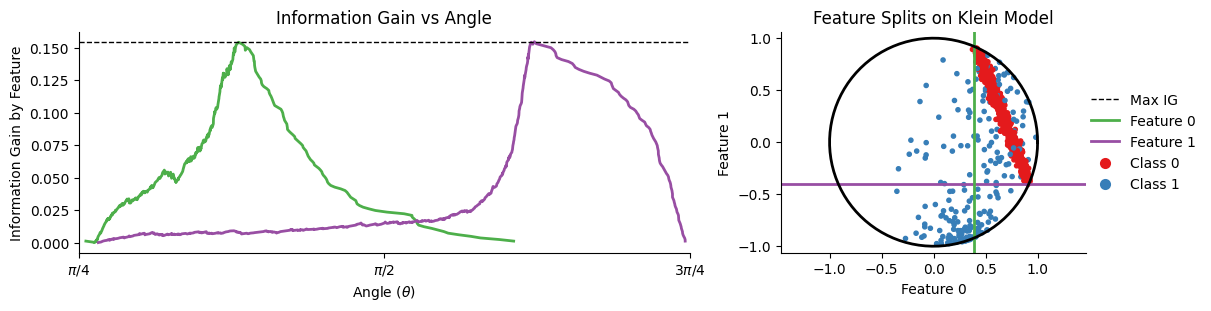

In [118]:
# Track information gain for some set of points
mybool = False
seed = 71
while not mybool:
    seed += 1
    X, y = wrapped_normal_mixture(num_points=1_000, seed=seed)

    feat0_vals_sorted = hdt._get_candidates(X, 1)
    feat1_vals_sorted = hdt._get_candidates(X, 2)

    feat0_igs, feat1_igs = [], []
    for vals, out in zip([feat0_vals_sorted, feat1_vals_sorted], [feat0_igs, feat1_igs]):
        for theta in vals:
            l, r = hdt._get_split(X, dim=1 if out is feat0_igs else 2, theta=theta)
            ig = hdt._information_gain(l, r, y)
            out.append(ig)
    mybool = np.isclose(max(feat0_igs), max(feat1_igs), atol=1e-3)

# Show the data and the splits
fig, axs = plt.subplots(1, 2, figsize=(12, 3), constrained_layout=True, gridspec_kw={'width_ratios': [2, 1]})

# Get colors from Set1, to match other plots
c0, c1, c2, c3 = plt.cm.Set1.colors[:4]

# First plot: IGs
axs[0].plot(feat0_vals_sorted, feat0_igs, label='Feature 0', c=c2, lw=2)
axs[0].plot(feat1_vals_sorted, feat1_igs, label='Feature 1', c=c3, lw=2)
axs[0].hlines(y=max(feat0_igs), xmin=np.pi / 4, xmax=3 * np.pi / 4, colors='k', linestyles='dashed', lw=1)
axs[0].set_xlim(np.pi / 4, 3 * np.pi / 4)
axs[0].set_xticks(np.linspace(np.pi / 4, 3 * np.pi / 4, 3), ["$\\pi/4$", "$\\pi/2$", "$3\\pi/4$"])
axs[0].set_ylabel("Information Gain")
axs[0].set_xlabel("Angle ($\\theta$)")
axs[0].set_ylabel("Information Gain by Feature")
axs[0].set_xlabel("Angle ($\\theta$)")
axs[0].set_title("Information Gain vs Angle")

# Second plot: splits on the Klein model
X_klein_dim0 = X[:, 1] / X[:, 0]
X_klein_dim1 = X[:, 2] / X[:, 0]
theta_dim0 = 1 / np.tan(feat0_vals_sorted[np.argmax(feat0_igs)])
theta_dim1 = 1 / np.tan(feat1_vals_sorted[np.argmax(feat1_igs)])
axs[1].scatter(X_klein_dim0, X_klein_dim1, c=[c0 if label == 0 else c1 for label in y], s=9)
axs[1].hlines(y=theta_dim1, xmin=-2, xmax=2, colors=c3, lw=2)
axs[1].vlines(x=theta_dim0, ymin=-2, ymax=2, colors=c2, lw=2)
axs[1].set_xlabel("Feature 0")
axs[1].set_ylabel("Feature 1")
axs[1].set_title("Feature Splits on Klein Model")

# Draw the circle as well
_thetas = np.linspace(0, 2 * np.pi, 100)
x = np.cos(_thetas)
y = np.sin(_thetas)
axs[1].plot(x, y, c="k", lw=2)
axs[1].axis('equal')
axs[1].set_xlim([-1.05, 1.05])
axs[1].set_ylim([-1.05, 1.05])

# Legend: blue and orange lines for Feature 0/1, red and blue dots for classes
artists = [
    axs[0].plot([], [], label="Max information gain", color="k", linestyle="dashed", lw=1)[0],
    axs[0].plot([], [], label='Feature 0', color=c2, lw=2)[0],
    axs[0].plot([], [], label='Feature 1', color=c3, lw=2)[0],
    axs[1].scatter([], [], label='Class 0', color=c0, lw=2),
    axs[1].scatter([], [], label='Class 1', color=c1, lw=2)
]
axs[1].legend(
    artists,
    ['Max IG', 'Feature 0', 'Feature 1', 'Class 0', 'Class 1'],
    loc='center right',
    bbox_to_anchor=(1.4, 0.5),
    shadow=False,
    frameon=False
)

# Remove top and right spines
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# plt.suptitle(f"Information Gain Analysis ($n=100$, seed={seed})")
# plt.tight_layout()
# plt.show()
plt.savefig("images/information_gain_analysis.pdf", bbox_inches='tight')

In [89]:
# Try across depths

# Testing copilot completions - multiline version
import numpy as np
import matplotlib.pyplot as plt

from hyperdt.legacy.tree import HyperbolicDecisionTreeClassifier as HDT
from hyperdt.tree import HyperbolicDecisionTreeClassifier as FastHDT
from hyperdt.toy_data import wrapped_normal_mixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import trange

TOTAL_TRIALS = 10
N_POINTS = 1_000
SKLEARN_SEED = 2 

np.random.seed(SKLEARN_SEED)
assert (np.random.permutation([0, 1]) == [1, 0]).all() # This is what it takes

# agreement_split = 1.0
# while agreement_split == 1.0:

match_rates = []

seed = -1
for max_depth in [1, 3, 5, 7, 9, None]:
    # n_match, n_ig_match, n_mismatch = 0, 0, 0
    match_rates_depth = []
    for i in trange(TOTAL_TRIALS):
        seed += 1
        try:
            X, y = wrapped_normal_mixture(num_points=N_POINTS, seed=seed)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

            dt_args = {"max_depth": max_depth, "min_samples_leaf": 1, "min_samples_split": 2}

            hdt = HDT(**dt_args)
            hdt.fit(X_train, y_train)    

            fhdt = FastHDT(**dt_args, random_state=SKLEARN_SEED) # Prevent permuting features randomly
            fhdt.fit(X_train, y_train)

            agreement_train, accuracy_hdt_train, accuracy_fhdt_train = compare_predictions(hdt, fhdt, X_train, y_train)
            agreement_test, accuracy_hdt_test, accuracy_fhdt_test = compare_predictions(hdt, fhdt, X_test, y_test)
            agreement_split, agreement_ig = compare_trees(fhdt, hdt, verbose=1)
            match_rates_depth.append((agreement_split, agreement_ig, agreement_train, agreement_test))
            
        except Exception as e:
            print(f"Error on trial {i}: {e}")
    match_rates.append(match_rates_depth)
    
    # match_rates.append((n_match, n_ig_match, agreement_train, agreement_test))


  0%|          | 0/10 [00:00<?, ?it/s]

 70%|███████   | 7/10 [00:04<00:02,  1.45it/s]

      Depth 3: sk(sk_feat=2, 2.2435)  vs  hd(hd_feat=1, 1.7163)  →  DIFF


 80%|████████  | 8/10 [00:05<00:01,  1.44it/s]

        Depth 4: sk(sk_feat=2, 1.4329)  vs  hd(hd_feat=1, 1.1343)  →  DIFF


 90%|█████████ | 9/10 [00:06<00:00,  1.45it/s]

    Depth 2: sk(sk_feat=1, 0.8893)  vs  hd(hd_feat=1, 0.8669)  →  DIFF
    Depth 2: sk(sk_feat=2, 0.8260)  vs  hd(hd_feat=1, 1.8454)  →  DIFF


 10%|█         | 1/10 [00:01<00:09,  1.08s/it]

  Depth 1: sk(sk_feat=2, 2.1539)  vs  hd(hd_feat=1, 2.3181)  →  DIFF


 20%|██        | 2/10 [00:01<00:07,  1.06it/s]

    Depth 2: sk(sk_feat=2, 1.4846)  vs  hd(hd_feat=1, 2.0836)  →  DIFF


 30%|███       | 3/10 [00:02<00:06,  1.11it/s]

          Depth 5: sk(sk_feat=2, 0.8337)  vs  hd(hd_feat=2, 0.7968)  →  DIFF


 40%|████      | 4/10 [00:03<00:04,  1.31it/s]

      Depth 3: sk(sk_feat=2, 1.3188)  vs  hd(hd_feat=1, 2.1045)  →  DIFF
            Depth 6: sk(sk_feat=1, 1.8233)  vs  hd(hd_feat=1, 1.8151)  →  DIFF
        Depth 4: sk(sk_feat=2, 2.2437)  vs  hd(hd_feat=1, 1.7480)  →  DIFF


 50%|█████     | 5/10 [00:04<00:03,  1.26it/s]

          Depth 5: sk(sk_feat=2, 1.9923)  vs  hd(hd_feat=1, 1.4108)  →  DIFF


 60%|██████    | 6/10 [00:05<00:03,  1.18it/s]

        Depth 4: sk(sk_feat=2, 1.8764)  vs  hd(hd_feat=1, 2.2185)  →  DIFF
          Depth 5: sk(sk_feat=2, 1.0053)  vs  hd(hd_feat=1, 1.9371)  →  DIFF


 70%|███████   | 7/10 [00:06<00:02,  1.11it/s]

          Depth 5: sk(sk_feat=2, 0.8641)  vs  hd(hd_feat=1, 1.4974)  →  DIFF


 80%|████████  | 8/10 [00:07<00:01,  1.12it/s]

            Depth 6: sk(sk_feat=2, 1.7638)  vs  hd(hd_feat=1, 2.3150)  →  DIFF
            Depth 6: sk(sk_feat=2, 1.6129)  vs  hd(hd_feat=1, 2.2323)  →  DIFF
        Depth 4: sk(sk_feat=2, 1.5362)  vs  hd(hd_feat=1, 2.1460)  →  DIFF


100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


          Depth 5: sk(sk_feat=2, 0.8999)  vs  hd(hd_feat=1, 1.1405)  →  DIFF
        Depth 4: sk(sk_feat=2, 0.8507)  vs  hd(hd_feat=1, 1.5696)  →  DIFF
            Depth 6: sk(sk_feat=2, 0.8798)  vs  hd(hd_feat=1, 1.3788)  →  DIFF
            Depth 6: sk(sk_feat=2, 1.6478)  vs  hd(hd_feat=1, 0.8776)  →  DIFF


 10%|█         | 1/10 [00:00<00:05,  1.69it/s]

              Depth 7: sk(sk_feat=1, 2.1397)  vs  hd(hd_feat=1, 2.1270)  →  DIFF
                Depth 8: sk(sk_feat=2, 1.2605)  vs  hd(hd_feat=1, 2.0760)  →  DIFF


 30%|███       | 3/10 [00:02<00:06,  1.15it/s]

                Depth 8: sk(sk_feat=2, 1.2685)  vs  hd(hd_feat=1, 1.3100)  →  DIFF


 40%|████      | 4/10 [00:03<00:05,  1.10it/s]

      Depth 3: sk(sk_feat=2, 2.1967)  vs  hd(hd_feat=1, 1.0574)  →  DIFF
                Depth 8: sk(sk_feat=2, 2.1768)  vs  hd(hd_feat=1, 1.2918)  →  DIFF
                Depth 8: sk(sk_feat=2, 2.1868)  vs  hd(hd_feat=1, 0.9657)  →  DIFF


 50%|█████     | 5/10 [00:04<00:05,  1.00s/it]

            Depth 6: sk(sk_feat=2, 1.6905)  vs  hd(hd_feat=1, 1.4526)  →  DIFF


 60%|██████    | 6/10 [00:05<00:03,  1.03it/s]

                Depth 8: sk(sk_feat=2, 1.7927)  vs  hd(hd_feat=1, 2.2983)  →  DIFF
            Depth 6: sk(sk_feat=1, 2.0571)  vs  hd(hd_feat=1, 1.8819)  →  DIFF
                Depth 8: sk(sk_feat=2, 1.5737)  vs  hd(hd_feat=2, 1.4871)  →  DIFF
          Depth 5: sk(sk_feat=1, 1.2933)  vs  hd(hd_feat=1, 0.8203)  →  DIFF


 70%|███████   | 7/10 [00:06<00:02,  1.06it/s]

                Depth 8: sk(sk_feat=1, 2.0025)  vs  hd(hd_feat=1, 1.5106)  →  DIFF
                Depth 8: sk(sk_feat=1, 1.3979)  vs  hd(hd_feat=1, 1.3761)  →  DIFF
                Depth 8: sk(sk_feat=2, 1.3507)  vs  hd(hd_feat=1, 1.1590)  →  DIFF


 80%|████████  | 8/10 [00:07<00:01,  1.08it/s]

                Depth 8: sk(sk_feat=2, 0.8912)  vs  hd(hd_feat=1, 1.4114)  →  DIFF
              Depth 7: sk(sk_feat=1, 1.5817)  vs  hd(hd_feat=1, 1.5417)  →  DIFF


 90%|█████████ | 9/10 [00:08<00:00,  1.05it/s]

            Depth 6: sk(sk_feat=1, 2.2842)  vs  hd(hd_feat=1, 2.2048)  →  DIFF
            Depth 6: sk(sk_feat=2, 0.8033)  vs  hd(hd_feat=1, 1.6307)  →  DIFF


100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


          Depth 5: sk(sk_feat=2, 2.2531)  vs  hd(hd_feat=1, 1.1114)  →  DIFF
        Depth 4: sk(sk_feat=2, 1.5424)  vs  hd(hd_feat=1, 1.7088)  →  DIFF


 10%|█         | 1/10 [00:01<00:14,  1.62s/it]

    Depth 2: sk(sk_feat=1, 1.4783)  vs  hd(hd_feat=1, 1.3263)  →  DIFF
        Depth 4: sk(sk_feat=1, 2.2702)  vs  hd(hd_feat=1, 0.9785)  →  DIFF
          Depth 5: sk(sk_feat=1, 2.2244)  vs  hd(hd_feat=1, 2.2267)  →  DIFF
      Depth 3: sk(sk_feat=2, 1.5797)  vs  hd(hd_feat=1, 2.3278)  →  DIFF
    Depth 2: sk(sk_feat=1, 2.0047)  vs  hd(hd_feat=1, 1.4808)  →  DIFF


 20%|██        | 2/10 [00:02<00:09,  1.15s/it]

              Depth 7: sk(sk_feat=2, 2.3311)  vs  hd(hd_feat=1, 1.6703)  →  DIFF
                        Depth 12: sk(sk_feat=2, 2.1046)  vs  hd(hd_feat=1, 1.7933)  →  DIFF
                              Depth 15: sk(sk_feat=2, 2.1256)  vs  hd(hd_feat=1, 1.6618)  →  DIFF
                  Depth 9: sk(sk_feat=1, 1.7307)  vs  hd(hd_feat=1, 1.7084)  →  DIFF
          Depth 5: sk(sk_feat=2, 1.8736)  vs  hd(hd_feat=1, 1.5700)  →  DIFF


 30%|███       | 3/10 [00:03<00:07,  1.05s/it]

        Depth 4: sk(sk_feat=1, 1.5364)  vs  hd(hd_feat=1, 1.0894)  →  DIFF
          Depth 5: sk(sk_feat=2, 1.2752)  vs  hd(hd_feat=1, 0.8920)  →  DIFF


 40%|████      | 4/10 [00:04<00:05,  1.04it/s]

      Depth 3: sk(sk_feat=2, 1.7800)  vs  hd(hd_feat=2, 1.7759)  →  DIFF
            Depth 6: sk(sk_feat=2, 1.5385)  vs  hd(hd_feat=1, 2.2905)  →  DIFF
  Depth 1: sk(sk_feat=1, 2.1632)  vs  hd(hd_feat=1, 2.1648)  →  DIFF


 50%|█████     | 5/10 [00:04<00:04,  1.14it/s]

                        Depth 12: sk(sk_feat=2, 2.1199)  vs  hd(hd_feat=1, 2.0878)  →  DIFF
        Depth 4: sk(sk_feat=2, 1.8493)  vs  hd(hd_feat=1, 2.2628)  →  DIFF


 60%|██████    | 6/10 [00:05<00:03,  1.23it/s]

          Depth 5: sk(sk_feat=2, 1.7754)  vs  hd(hd_feat=1, 2.1037)  →  DIFF


 70%|███████   | 7/10 [00:06<00:02,  1.07it/s]

      Depth 3: sk(sk_feat=2, 2.2350)  vs  hd(hd_feat=1, 1.4853)  →  DIFF
              Depth 7: sk(sk_feat=2, 1.3881)  vs  hd(hd_feat=1, 1.5455)  →  DIFF
          Depth 5: sk(sk_feat=2, 2.2124)  vs  hd(hd_feat=1, 1.2697)  →  DIFF
          Depth 5: sk(sk_feat=2, 2.1696)  vs  hd(hd_feat=1, 0.9608)  →  DIFF
              Depth 7: sk(sk_feat=1, 0.9799)  vs  hd(hd_feat=1, 0.9222)  →  DIFF
                Depth 8: sk(sk_feat=1, 0.9695)  vs  hd(hd_feat=1, 0.9649)  →  DIFF
                      Depth 11: sk(sk_feat=2, 1.9340)  vs  hd(hd_feat=1, 0.8939)  →  DIFF
                      Depth 11: sk(sk_feat=2, 1.9031)  vs  hd(hd_feat=1, 1.0059)  →  DIFF
          Depth 5: sk(sk_feat=2, 1.2169)  vs  hd(hd_feat=1, 1.3988)  →  DIFF
                  Depth 9: sk(sk_feat=2, 1.2340)  vs  hd(hd_feat=1, 1.0939)  →  DIFF


 80%|████████  | 8/10 [00:08<00:02,  1.03s/it]

      Depth 3: sk(sk_feat=2, 1.7863)  vs  hd(hd_feat=1, 2.3432)  →  DIFF
                Depth 8: sk(sk_feat=1, 2.3338)  vs  hd(hd_feat=1, 2.3259)  →  DIFF
              Depth 7: sk(sk_feat=2, 1.7645)  vs  hd(hd_feat=1, 2.3393)  →  DIFF
            Depth 6: sk(sk_feat=1, 2.3171)  vs  hd(hd_feat=1, 2.3043)  →  DIFF
                  Depth 9: sk(sk_feat=2, 1.5086)  vs  hd(hd_feat=1, 2.0854)  →  DIFF
                    Depth 10: sk(sk_feat=1, 1.9896)  vs  hd(hd_feat=1, 1.9747)  →  DIFF
              Depth 7: sk(sk_feat=2, 1.0354)  vs  hd(hd_feat=2, 1.0037)  →  DIFF
          Depth 5: sk(sk_feat=2, 0.8516)  vs  hd(hd_feat=1, 1.1433)  →  DIFF


 90%|█████████ | 9/10 [00:09<00:01,  1.02s/it]

                Depth 8: sk(sk_feat=1, 1.8484)  vs  hd(hd_feat=1, 1.8190)  →  DIFF
              Depth 7: sk(sk_feat=2, 2.2842)  vs  hd(hd_feat=1, 1.1912)  →  DIFF
                Depth 8: sk(sk_feat=2, 2.2567)  vs  hd(hd_feat=1, 1.1919)  →  DIFF
            Depth 6: sk(sk_feat=2, 2.1265)  vs  hd(hd_feat=1, 1.3329)  →  DIFF
                Depth 8: sk(sk_feat=2, 1.0865)  vs  hd(hd_feat=1, 2.1376)  →  DIFF


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]

                  Depth 9: sk(sk_feat=2, 2.2110)  vs  hd(hd_feat=2, 2.2106)  →  DIFF
              Depth 7: sk(sk_feat=1, 1.8750)  vs  hd(hd_feat=1, 1.7980)  →  DIFF


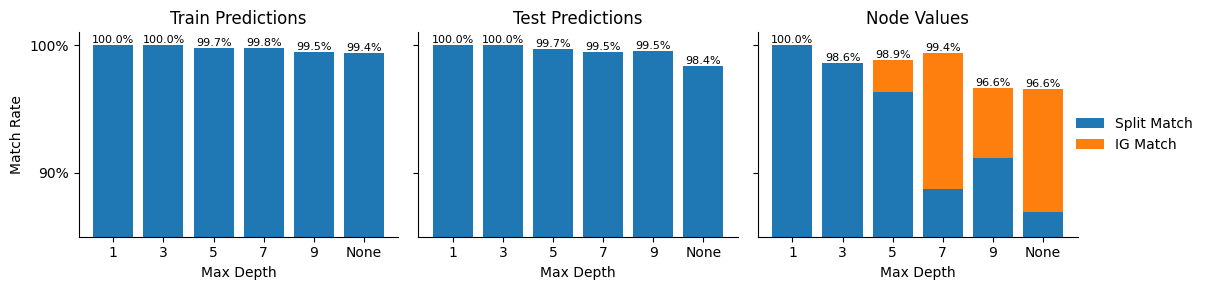

In [112]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

# Process
depths = [1, 3, 5, 7, 9, None]
matches = [np.mean([trial[0] for trial in match_rates[i]]) for i in range(len(depths))]
ig_only_matches = [np.mean([trial[1] - trial[0] for trial in match_rates[i]]) for i in range(len(depths))]
train_agreements = [np.mean([trial[2] for trial in match_rates[i]]) for i in range(len(depths))]
test_agreements = [np.mean([trial[3] for trial in match_rates[i]]) for i in range(len(depths))]

# Create the stacked bar plot
depths_labels = ['1', '3', '5', '7', '9', 'None']
bottom_bars = ax2.bar(depths_labels, matches, label='Split Match')
top_bars = ax2.bar(depths_labels, ig_only_matches, bottom=matches, label='IG Match')

# Customize the plot for node values
ax2.set_xlabel('Max Depth')
ax2.set_title('Node Values')
ax2.legend(loc="center right", bbox_to_anchor=(1.4, 0.5), shadow=False, frameon=False)

# Add total numbers on top of bars
for i in range(len(depths)):
    total = matches[i] + ig_only_matches[i]
    ax2.text(i, total, f'{total * 100:.1f}%', ha='center', va='bottom', fontsize=8)

# Create bar plots for train and test predictions
for vals, ax, title in zip([train_agreements, test_agreements],
                             [ax0, ax1],
                             ["Train Predictions", "Test Predictions"]):
    ax.bar(depths_labels, vals, label=title)
    for i in range(len(depths)):
        ax.text(i, vals[i], f'{vals[i] * 100:.1f}%', ha='center', va='bottom', fontsize=8)
    ax.set_xlabel('Max Depth')
    ax.set_title(title)

# Remove top and right spines
for ax in [ax0, ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Set y-axis as percentages for the train predictions plot
ax0.set_ylabel("Match Rate")
ax0.set_yticks(np.linspace(0, 1, 11))
ax0.set_yticklabels([f'{i}%' for i in range(0, 101, 10)])
ax0.set_ylim(0.85, 1.01)

plt.tight_layout()
plt.savefig("images/matches.pdf", bbox_inches='tight', dpi=300)